In [1]:
!pip install uproot awkward 
from uproot_io import Events, View
import numpy as np
import matplotlib.pyplot as plt
import features as u

cheated_0 = Events('CheatedRecoFile_0.root')

# we have 499617 events in cheated_0

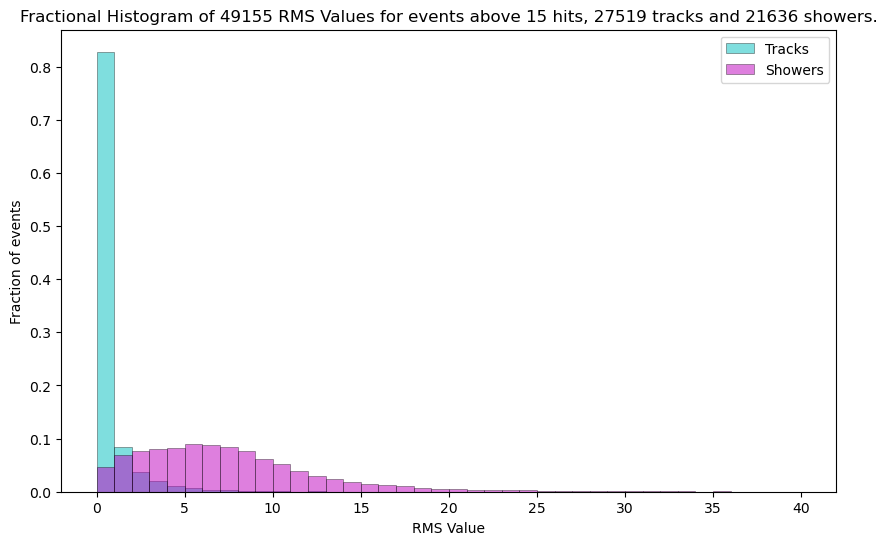

In [2]:
from features import rms_pdg

def var_rms(events, start_idx, end_idx, hits_cutoff, show_plot=False):
    if not isinstance(start_idx, int) or not isinstance(end_idx, int) or start_idx < 0 or end_idx < 0 or start_idx > end_idx:
        return print('invalid entry of indices')

    track_rms = []
    shower_rms = []
    # loop over all particles between start/end idx inclusive
    for i in range(start_idx, 1 + end_idx):
        try:
            rms_value, indicator = rms_pdg(events, i, hits_cutoff)
            # Proceed to add to the appropriate list based on the indicator
            if rms_value is not None:
                if indicator == 'T':
                    track_rms.append(rms_value)
                elif indicator == 'S':
                    shower_rms.append(rms_value)
        except TypeError:
            # This block will execute if rms_pdg(i) returns None, skipping the unpacking
            pass

    # Manually get the fraction
    n_t = len(track_rms)
    n_s = len(shower_rms)
    
    # Define bin edges
    bin_edges = np.arange(0, 41, 1)
    
    # Calculate fractional weights for each entry
    track_weights = np.ones_like(track_rms) / n_t if n_t > 0 else np.zeros_like(track_rms)
    shower_weights = np.ones_like(shower_rms) / n_s if n_s > 0 else np.zeros_like(shower_rms)

    # Calculate histogram bin heights (fractional values) and store them in arrays
    track_bin_heights, _ = np.histogram(track_rms, bins=bin_edges, weights=track_weights)
    shower_bin_heights, _ = np.histogram(shower_rms, bins=bin_edges, weights=shower_weights)

    # Plot the histogram with fractional bin heights
    plt.figure(figsize=(10, 6))
    plt.hist(track_rms, bins=bin_edges, weights=track_weights, color='c', edgecolor='k', linewidth=0.5, alpha=0.5, label='Tracks')
    plt.hist(shower_rms, bins=bin_edges, weights=shower_weights, color='m', edgecolor='k', linewidth=0.5, alpha=0.5, label='Showers')

    # Set plot details
    plt.title(f'Fractional Histogram of {n_t + n_s} RMS Values for events above {hits_cutoff} hits, {n_t} tracks and {n_s} showers.')
    plt.xlabel('RMS Value')
    plt.ylabel('Fraction of events')
    plt.legend()
    plt.grid(False)
    if show_plot:
        plt.show()

    return track_bin_heights, shower_bin_heights, bin_edges

training_data_example = var_rms(cheated_0, 0, 499616, 15, True)

In [3]:
# if we now look at cheated 10 again to pretend its our data:
from features import rms

cheated_10 = Events("CheatedRecoFile_10.root")

def p_rms(training_data, testing_events, event_idx): # training_data is a tuple of arrays: track_bin_heights, shower_bin_heights; testing events: an events class; event_idx as usual
    pdf_t, pdf_s = training_data
    bin_edges = np.arange(0, 31, 1)

    val = rms(testing_events, event_idx, 2)

    p_idx = np.searchsorted(bin_edges, val) - 1
    
    p_t = pdf_t[p_idx]
    p_s = pdf_s[p_idx]

    return [p_t, p_s]

p1 = p_rms(training_data_example, cheated_10, 3011) # example, definite shower
print(f'Probability of track, shower: {p1}')
L_shower = p1[1]/(p1[0] + p1[1])
L_track = p1[0]/(p1[0] + p1[1])

print(f'Likelihood of a track: {L_track}')
print(f'Likelihood of a shower: {L_shower}')

u.plot_idx(cheated_10, 3011)

ValueError: too many values to unpack (expected 2)